In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import matplotlib.dates as mdates
import tensorflow as tf

from src.globals import processed_data_dir, saved_model_dir, vis_dir
from src.helpers import WindowGenerator, get_filenames_in_directory
from src.visualization import plot_metrics

In [20]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [21]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [23]:
train_files = get_filenames_in_directory(train_dir)

In [24]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) -1  # number of columns without embedding column
n_features

11

In [25]:
# number of locations for embedding inputs
# 6
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

6

In [26]:
# Model configs
INPUT_WIDTH = 24  * 3
LABEL_WIDTH = 24
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

In [27]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')

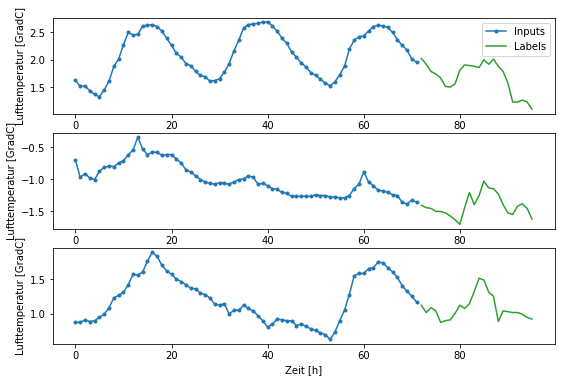

In [28]:
w1.plot()

# Define model & metrics

In [29]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH,))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([ embedding_layer, feature_inputs])

lstm_layer = tf.keras.layers.LSTM(10, return_sequences=True)(concat_layer)
lstm_layer = tf.keras.layers.LSTM(10, return_sequences=True)(lstm_layer)
lstm_layer = tf.keras.layers.LSTM(10, return_sequences=True)(lstm_layer)[:,-LABEL_WIDTH:,:]

# Apply a dense output layer on every timestep of the LSTM
output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=1, activation='linear')
)(lstm_layer)

# Build the model
#model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

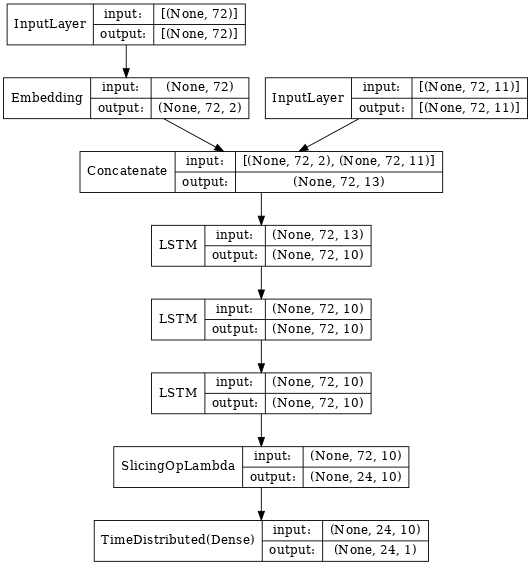

In [30]:
tf.keras.utils.plot_model(
    model, to_file=vis_dir/'lstm.png', show_shapes=True, 
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=64
)

# Train model

In [31]:
# Train configs
MAX_EPOCHS = 50

In [32]:
METRICS = [
      tf.keras.metrics.MeanAbsoluteError(name='MAE')
]

In [33]:
def compile_and_fit(model,
                    train_dataset,
                    validation_dataset,
                    save_to=None, 
                    patience=3, 
                    lr=1e-4, 
                    max_epochs=MAX_EPOCHS,
                    metrics=METRICS,
                    batch_size=BATCH_SIZE,
                    verbose=True):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    
    save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_to,
                                                         save_weights_only=False,
                                                         monitor='val_loss',
                                                         mode='min',
                                                         save_best_only=True,
                                                         save_freq='epoch')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=lr),
                metrics=metrics)

    history = model.fit(train_dataset, epochs=max_epochs,
                      validation_data=validation_dataset,
                      callbacks=[early_stopping],
                      batch_size=batch_size,
                      verbose=verbose)
                      
    return history

In [34]:
model_name = 'lstm_basic_' + \
        datetime.datetime.today().strftime('%y%m%d')

history = compile_and_fit(model, w1.train, w1.val, save_to=str(saved_model_dir/model_name))

Epoch 1/50
210/210 [==============================] - 42s 178ms/step - loss: 0.9895 - MAE: 0.8255 - val_loss: 1.0722 - val_MAE: 0.8564
Epoch 2/50
210/210 [==============================] - 53s 245ms/step - loss: 0.6421 - MAE: 0.6412 - val_loss: 0.6470 - val_MAE: 0.6186
Epoch 3/50
210/210 [==============================] - 63s 289ms/step - loss: 0.3250 - MAE: 0.4437 - val_loss: 0.5405 - val_MAE: 0.5619
Epoch 4/50
210/210 [==============================] - 53s 240ms/step - loss: 0.2899 - MAE: 0.4187 - val_loss: 0.4965 - val_MAE: 0.5370
Epoch 5/50
210/210 [==============================] - 50s 232ms/step - loss: 0.2605 - MAE: 0.3968 - val_loss: 0.4666 - val_MAE: 0.5191
Epoch 6/50
 75/210 [=========>....................] - ETA: 30s - loss: 0.2566 - MAE: 0.3924

In [ ]:
model.save(str(saved_model_dir/model_name))

[2021-08-28 20:24:52 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.
[2021-08-28 20:24:52 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210828/assets


[2021-08-28 20:24:53 | builder_impl] Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210828/assets


Text(0, 0.5, 'val_loss')

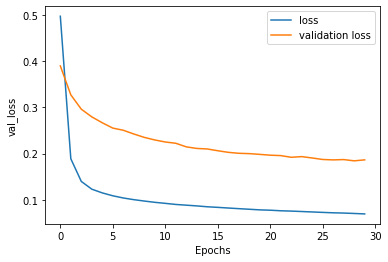

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels = ["loss", "validation loss"])
plt.xlabel("Epochs")
plt.ylabel("val_loss")

In [ ]:
model.evaluate(w1.test)

42/42 [==============================] - 4s 52ms/step - loss: 0.1795 - MAE: 0.3116


[0.17951487004756927, 0.31160280108451843]

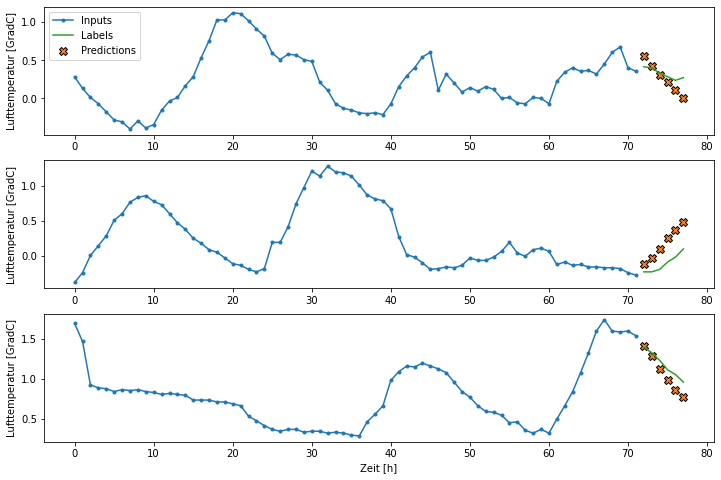

In [ ]:
w1.plot(model=model)